Import Library

In [3]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

#tensorflow 관련 Library
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

import matplotlib.pyplot as plt
import numpy as np

drive.mount('/content/drive')

## Move your Directiory (using cd or os.chdir)
os.chdir('/content/drive/MyDrive/dataset')

gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Num GPUs Available:  1


Kaggle에서 데이터 가져오기

In [4]:
# Download latest version
path = os.getcwd()

print("Path to dataset files:", path)

Path to dataset files: /content/drive/.shortcut-targets-by-id/1Yab2UmT9wqvuvvUZDoealbNbPV9pknbR/dataset


Data set 전처리 및 생성

In [5]:
img_size = (244,244)

# 이미지 데이터 증강 (Data Augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,         # 정규화 (0~1 범위)
    width_shift_range=0.2,  # 좌우 이동 (이미지 너비의 20%)
    height_shift_range=0.2, # 상하 이동 (이미지 높이의 20%)
    zoom_range=0.2,         # 랜덤 줌 (최대 20%)
    fill_mode='nearest',    # 빈 픽셀을 보완하는 방식 (nearest, constant, reflect 등)
    validation_split=0.2    # 검증 데이터 분리 (20%)
)

train_path = path + "/train_set"
test_path  = path + "/test_set"

# 학습 데이터 로드
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_size[0], img_size[1]),
    batch_size=32,
    shuffle= True,
    class_mode='categorical',
    subset="training",
    classes = ['Abrasion','Burn','Bruise' ,'Warts','Rosacea','Acne','Tinea']
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# 검증 데이터 로드
val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=(img_size[0], img_size[1]),
    batch_size=32,
    shuffle= False,
    class_mode='categorical',
    subset="validation",
    classes = ['Abrasion','Burn','Bruise' ,'Warts','Rosacea','Acne','Tinea']
)

test_datagen = ImageDataGenerator(rescale=1./255)

# 테스트 데이터 로드
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_size[0], img_size[1]),
    batch_size=32,
    shuffle= False,
    class_mode='categorical',
    classes = ['Abrasion','Burn','Bruise' ,'Warts','Rosacea','Acne','Tinea']
)

print(np.bincount(train_generator.classes))
print(np.bincount(val_generator.classes))

Found 2175 images belonging to 7 classes.
Found 539 images belonging to 7 classes.
Found 210 images belonging to 7 classes.
[426 108 453 236 212 556 184]
[106  26 113  58  52 139  45]


In [ ]:
n_channels = train_generator.image_shape[-1]
classes = train_generator.class_indices
n_classes = train_generator.num_classes

n_train = train_generator.samples
n_val = val_generator.samples

print(n_train, n_val)

2255 559


Show a Sample Data

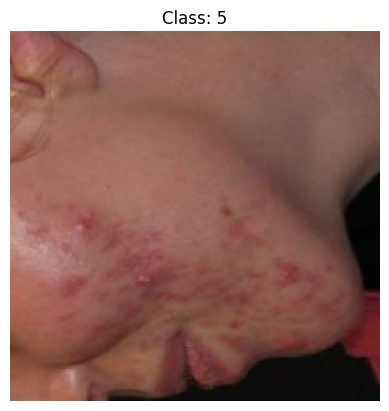

In [ ]:
# 배치에서 랜덤하게 이미지 하나 가져오기
batch_images, batch_labels = next(train_generator)  # 배치 가져오기
idx = np.random.randint(batch_images.shape[0])  # 배치 내 랜덤 인덱스 선택

# 선택한 이미지 및 라벨 출력
plt.imshow(batch_images[idx])
plt.title(f"Class: {np.argmax(batch_labels[idx])}")  # One-Hot Encoding -> 정수 라벨 변환
plt.axis("off")
plt.show()

Building Input Data Pipelines

In [ ]:
# Load the MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape = train_generator.image_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build a new model on top of the pre-trained base
def build_transfer_learning_model(num_classes):
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


<ipython-input-12-beb51d516a45>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape = train_generator.image_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Training the Model

In [ ]:
# Build the transfer learning model
transfer_learning_model = build_transfer_learning_model(n_classes)

# Learning rate schedule callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Early Stopping callback (과적합 방지)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

# Train the model
history_transfer_learning = transfer_learning_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate on the test set
test_loss, test_accuracy = transfer_learning_model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 514s 7s/step - accuracy: 0.5238 - loss: 1.4031 - val_accuracy: 0.7800 - val_loss: 0.6393 - learning_rate: 0.0010
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.8188 - loss: 0.5010 - val_accuracy: 0.7943 - val_loss: 0.5962 - learning_rate: 0.0010
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 187ms/step - accuracy: 0.8632 - loss: 0.3732 - val_accuracy: 0.7853 - val_loss: 0.5735 - learning_rate: 0.0010
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 169ms/step - accuracy: 0.8987 - loss: 0.2855 - val_accuracy: 0.7996 - val_loss: 0.6187 - learning_rate: 0.0010
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 187ms/step - accuracy: 0.9124 - loss: 0.2332 - val_accuracy: 0.7961 - val_loss: 0.5637 - learning_rate: 0.0010
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - accuracy: 0.9420 - loss: 0.1676 - val_accuracy: 0.8408 - val_loss: 0.4564 - learning_rate: 0.0010
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - accuracy: 0.9528 - loss: 0.14

NameError: name 'test_generator' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
pred2 = transfer_learning_model.predict(test_generator)
y_pred = np.argmax(pred2, axis=1)
y_true = test_generator.labels
print(classification_report(y_true, y_pred))
accuracy = accuracy_score(y_true, y_pred) * 100
print("Accuracy of the Model: {:.1f}%".format(accuracy))

18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       126
           1       0.68      0.88      0.77        26
           2       0.97      1.00      0.99       113
           3       0.82      0.69      0.75        58
           4       0.73      0.67      0.70        52
           5       0.92      0.86      0.88       139
           6       0.85      0.78      0.81        45

    accuracy                           0.87       559
   macro avg       0.83      0.84      0.83       559
weighted avg       0.88      0.87      0.87       559

Accuracy of the Model: 87.5%


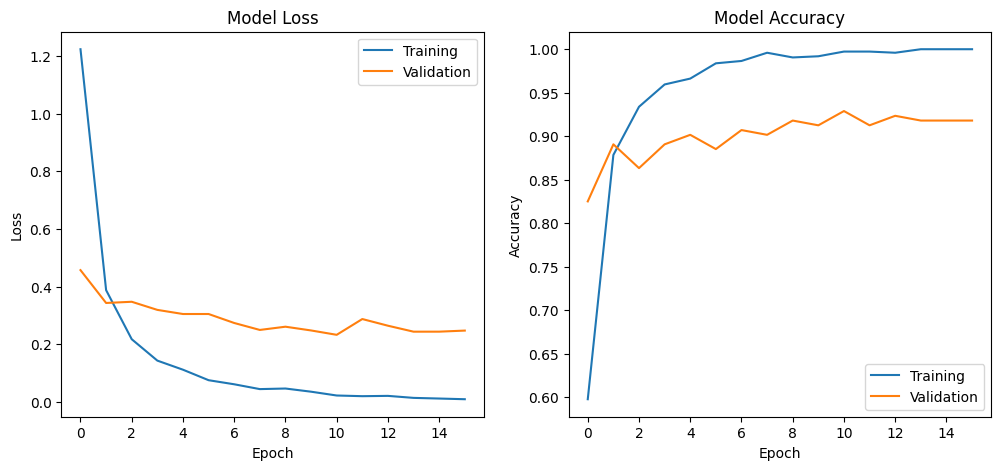

In [ ]:
# 손실 (Loss) 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째 그래프
plt.plot(history_transfer_learning.history['loss'])
plt.plot(history_transfer_learning.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

# 정확도 (Accuracy) 그래프
plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째 그래프
plt.plot(history_transfer_learning.history['accuracy'])
plt.plot(history_transfer_learning.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

In [ ]:
transfer_learning_model.save("my_model.keras")